In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import pickle
import os
import h5py
import collections as cl
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
import random
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from deem import deem

In [3]:
param_grid = {'LR_param': {'C':[10**k for k in range(-10, 6, 2)]}, 'scoring': 'roc_auc', 'cv': 3, 'random_state': 42}

with open("genre_map.json", "r") as f: # only consider 10 classes of Openmic dataset
    genre_map = json.load(f)
aligned_genre = list(genre_map)[:-1]

with open("instrument_map.json", "r") as f: # only consider 10 classes of Openmic dataset
    instrument_map = json.load(f)

## in-domain performance

In [6]:
debias_method = ''
indomain_performance = pd.DataFrame(columns=['instrument', 'test set', 'embedding', 'in-domain performance'])

for embedding in ['vggish', 'openl3', 'yamnet']:

    df = pd.read_csv('results/results_' + embedding +  debias_method + '.csv')
    A_drop = df.loc[(df['train_set'] == 'A') & (df['test_set'] == 'A')]['roc_auc'].values

    B_drop = df.loc[(df['train_set'] == 'B') & (df['test_set'] == 'B')]['roc_auc'].values

    item_drop = pd.DataFrame(columns=['instrument', 'test set', 'embedding', 'in-domain performance'])
    item_drop['instrument'] = list(instrument_map) * 2
    item_drop['test set'] = ['A'] * len(instrument_map) + ['B'] * len(instrument_map)
    item_drop['embedding'] = [embedding] * len(instrument_map) * 2
    item_drop['in-domain performance'] = list(A_drop) + list(B_drop)

    indomain_performance = indomain_performance.append(item_drop)

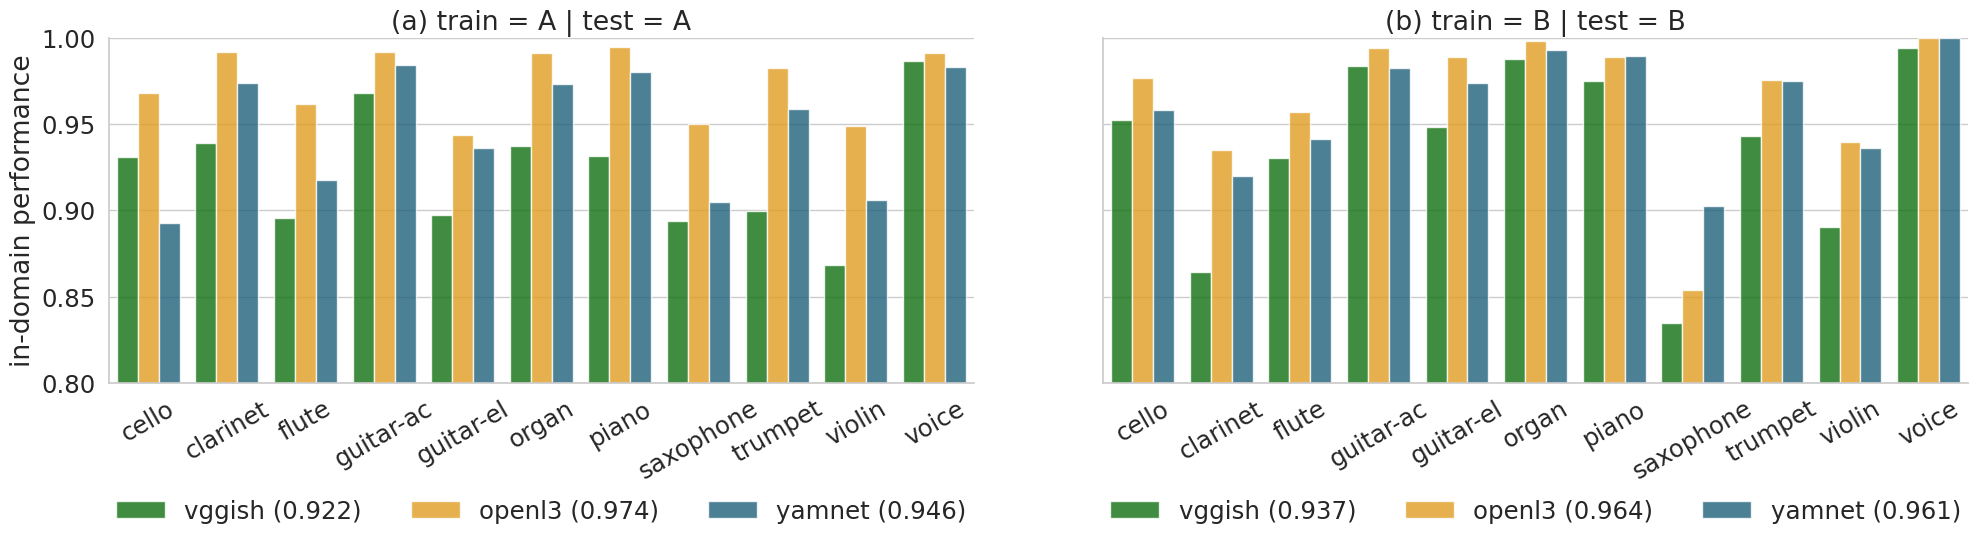

In [7]:
sns.set_theme(context='notebook', style='whitegrid', font_scale=1.6)
colors = ['green', 'orange', '#0e668b']
hue_order = ['vggish', 'openl3', 'yamnet']
    
df = indomain_performance
ax = sns.catplot(data=df, col='test set', x='instrument', y='in-domain performance', hue='embedding', kind='bar', aspect=2, 
               legend_out=False, palette=colors, hue_order=hue_order, alpha = 0.8)
a0 = ax.fig.axes[0]
a0.set_title("(a) train = A | test = A")
a0.set_ylim([.8,1])
handles, labels = a0.get_legend_handles_labels()
df_A = df[df['test set']=='A']
text = [a0.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_A[df_A['embedding']==hue_order[l]]['in-domain performance'].mean(), 3)) + ')' for l in range(len(hue_order))]
a0.legend(handles, text)
lgd = sns.move_legend(a0, "lower center", bbox_to_anchor=(.5, -.47), ncol=3, title=None, frameon=False)

a1 = ax.fig.axes[1]
a1.set_title("(b) train = B | test = B")
a1.set_ylim([.8,1])
handles, labels = a1.get_legend_handles_labels()
df_B = df[df['test set']=='B']
text = [a1.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_B[df_B['embedding']==hue_order[l]]['in-domain performance'].mean(), 3)) + ')' for l in range(len(hue_order))]
a1.legend(handles, text)
lgd = sns.move_legend(a1, "lower center", bbox_to_anchor=(.5, -.47), ncol=3, title=None, frameon=False)

ax.set(xlabel=None)
plt.subplots_adjust(wspace=0.15)
ax.set_xticklabels(rotation=30)

plt.savefig('results/indomain_performance.pdf', bbox_inches='tight')
# plt.savefig('results/cosine_similarity.png', bbox_inches='tight')

## cross-domain before debiasing

In [8]:
crossdomain_performance = pd.DataFrame(columns=['instrument', 'test set', 'embedding', 'cross-domain performance'])

for embedding in ['vggish', 'openl3', 'yamnet']:

    df = pd.read_csv('results/results_' + embedding +  debias_method + '.csv')
    A_drop = df.loc[(df['train_set'] == 'B') & (df['test_set'] == 'A')]['roc_auc'].values

    B_drop = df.loc[(df['train_set'] == 'A') & (df['test_set'] == 'B')]['roc_auc'].values

    item_drop = pd.DataFrame(columns=['instrument', 'test set', 'embedding', 'cross-domain performance'])
    item_drop['instrument'] = list(instrument_map) * 2
    item_drop['test set'] = ['A'] * len(instrument_map) + ['B'] * len(instrument_map)
    item_drop['embedding'] = [embedding] * len(instrument_map) * 2
    item_drop['cross-domain performance'] = list(A_drop) + list(B_drop)

    crossdomain_performance = crossdomain_performance.append(item_drop)

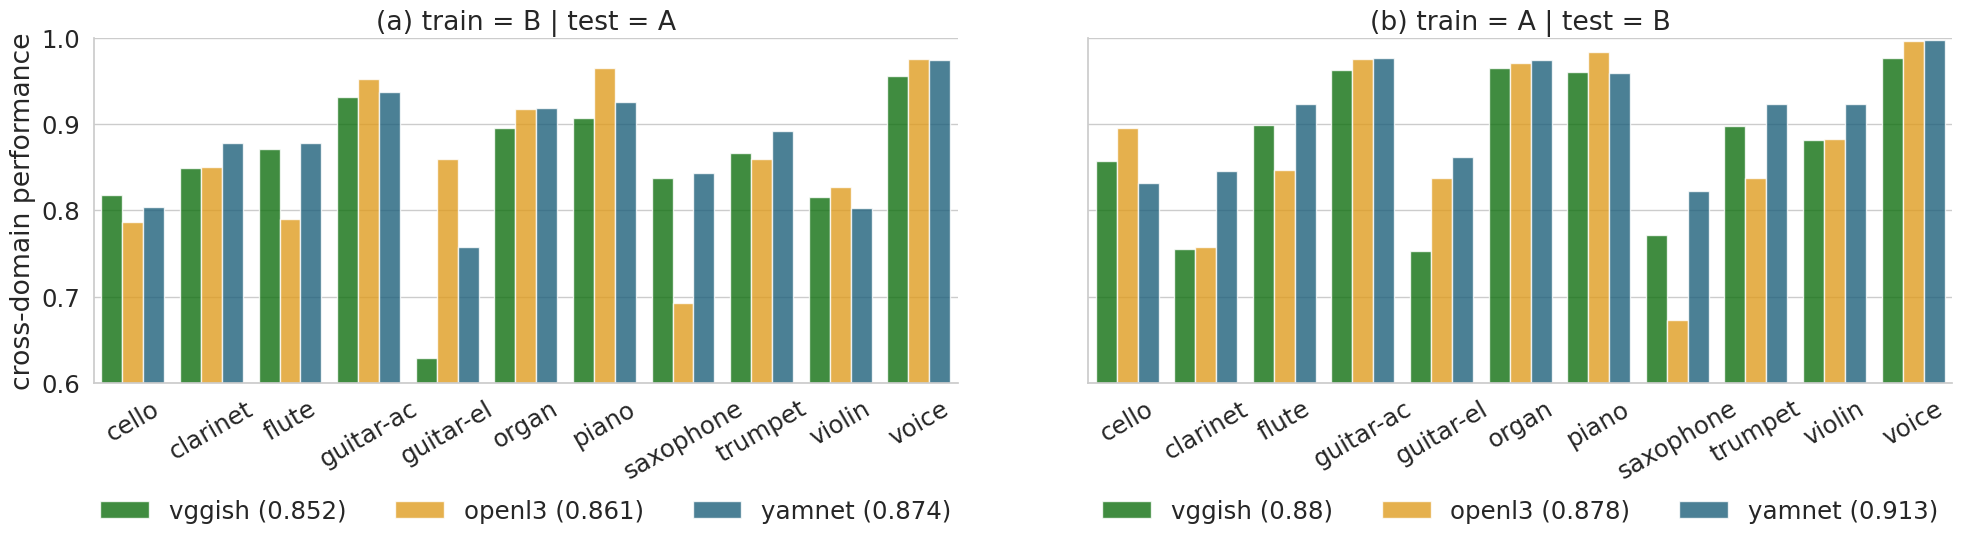

In [9]:
sns.set_theme(context='notebook', style='whitegrid', font_scale=1.6)
colors = ['green', 'orange', '#0e668b']
hue_order = ['vggish', 'openl3', 'yamnet']
    
df = crossdomain_performance
ax = sns.catplot(data=df, col='test set', x='instrument', y='cross-domain performance', hue='embedding', kind='bar', aspect=2, 
               legend_out=False, palette=colors, hue_order=hue_order, alpha = 0.8)
a0 = ax.fig.axes[0]
a0.set_title("(a) train = B | test = A")
a0.set_ylim([.6,1])
handles, labels = a0.get_legend_handles_labels()
df_A = df[df['test set']=='A']
text = [a0.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_A[df_A['embedding']==hue_order[l]]['cross-domain performance'].mean(), 3)) + ')' for l in range(len(hue_order))]
a0.legend(handles, text)
lgd = sns.move_legend(a0, "lower center", bbox_to_anchor=(.5, -.47), ncol=3, title=None, frameon=False)

a1 = ax.fig.axes[1]
a1.set_title("(b) train = A | test = B")
a1.set_ylim([.6,1])
handles, labels = a1.get_legend_handles_labels()
df_B = df[df['test set']=='B']
text = [a1.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_B[df_B['embedding']==hue_order[l]]['cross-domain performance'].mean(), 3)) + ')' for l in range(len(hue_order))]
a1.legend(handles, text)
lgd = sns.move_legend(a1, "lower center", bbox_to_anchor=(.5, -.47), ncol=3, title=None, frameon=False)

ax.set(xlabel=None)
plt.subplots_adjust(wspace=0.15)
ax.set_xticklabels(rotation=30)

plt.savefig('results/crossdomain_performance_before.pdf', bbox_inches='tight')
# plt.savefig('results/cosine_similarity.png', bbox_inches='tight')

## cross-domain after debiasing

In [10]:
crossdomain_performance = pd.DataFrame(columns=['instrument', 'test set', 'embedding', 'cross-domain performance'])
debias_method = '-lda'

for embedding in ['vggish', 'openl3', 'yamnet']:

    df = pd.read_csv('results/results_' + embedding +  debias_method + '.csv')
    A_drop = df.loc[(df['train_set'] == 'B') & (df['test_set'] == 'A') & 
                    (df['embedding'] == embedding +  debias_method)]['roc_auc'].values

    B_drop = df.loc[(df['train_set'] == 'A') & (df['test_set'] == 'B')& 
                    (df['embedding'] == embedding +  debias_method)]['roc_auc'].values

    item_drop = pd.DataFrame(columns=['instrument', 'test set', 'embedding', 'cross-domain performance'])
    item_drop['instrument'] = list(instrument_map) * 2
    item_drop['test set'] = ['A'] * len(instrument_map) + ['B'] * len(instrument_map)
    item_drop['embedding'] = [embedding] * len(instrument_map) * 2
    item_drop['cross-domain performance'] = list(A_drop) + list(B_drop)

    crossdomain_performance = crossdomain_performance.append(item_drop)

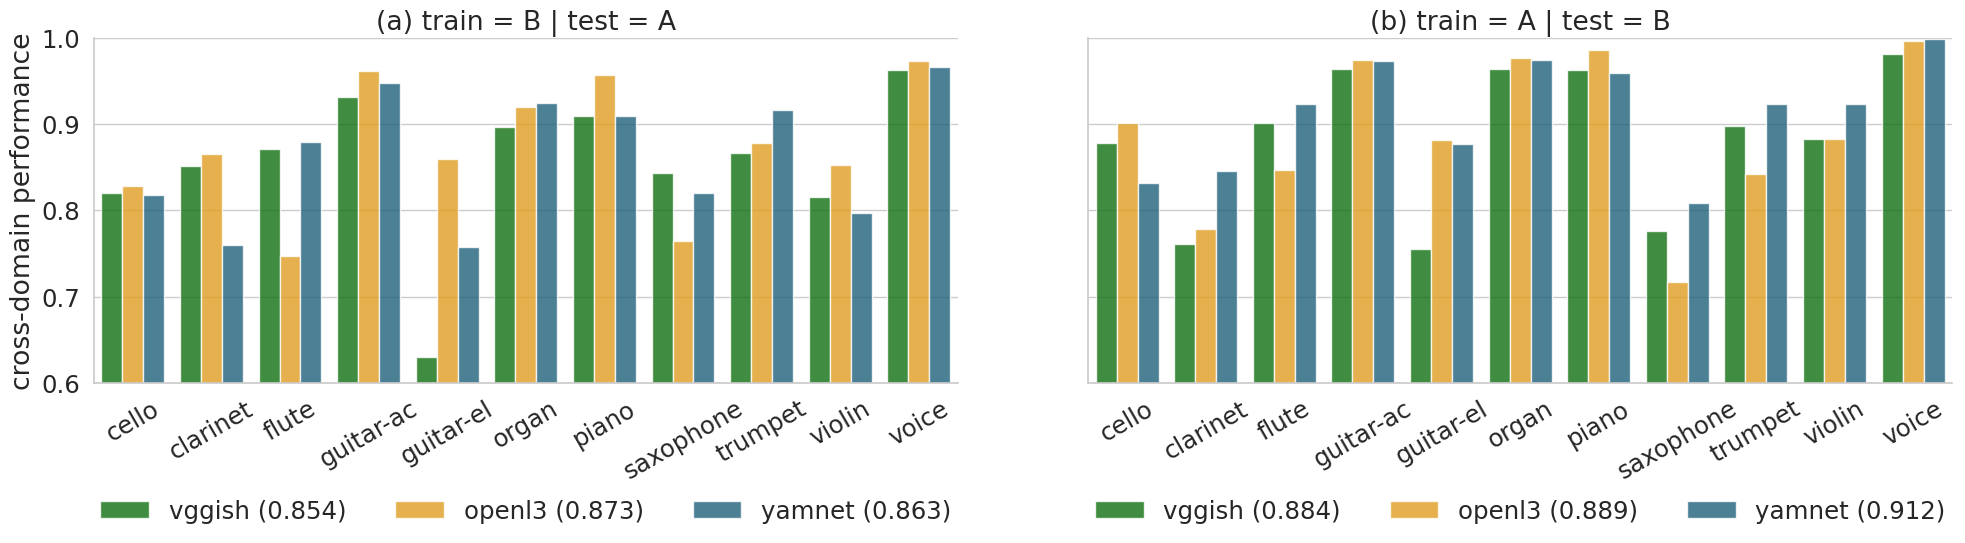

In [11]:
sns.set_theme(context='notebook', style='whitegrid', font_scale=1.6)
colors = ['green', 'orange', '#0e668b']
hue_order = ['vggish', 'openl3', 'yamnet']
    
df = crossdomain_performance
ax = sns.catplot(data=df, col='test set', x='instrument', y='cross-domain performance', hue='embedding', kind='bar', aspect=2, 
               legend_out=False, palette=colors, hue_order=hue_order, alpha = 0.8)
a0 = ax.fig.axes[0]
a0.set_title("(a) train = B | test = A")
a0.set_ylim([.6,1])
handles, labels = a0.get_legend_handles_labels()
df_A = df[df['test set']=='A']
text = [a0.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_A[df_A['embedding']==hue_order[l]]['cross-domain performance'].mean(), 3)) + ')' for l in range(len(hue_order))]
a0.legend(handles, text)
lgd = sns.move_legend(a0, "lower center", bbox_to_anchor=(.5, -.47), ncol=3, title=None, frameon=False)

a1 = ax.fig.axes[1]
a1.set_title("(b) train = A | test = B")
a1.set_ylim([.6,1])
handles, labels = a1.get_legend_handles_labels()
df_B = df[df['test set']=='B']
text = [a1.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_B[df_B['embedding']==hue_order[l]]['cross-domain performance'].mean(), 3)) + ')' for l in range(len(hue_order))]
a1.legend(handles, text)
lgd = sns.move_legend(a1, "lower center", bbox_to_anchor=(.5, -.47), ncol=3, title=None, frameon=False)

ax.set(xlabel=None)
plt.subplots_adjust(wspace=0.15)
ax.set_xticklabels(rotation=30)

plt.savefig('results/crossdomain_performance_lda.pdf', bbox_inches='tight')
# plt.savefig('results/cosine_similarity.png', bbox_inches='tight')